In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

In [4]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

### 【問題１〜９】パターン①
###   ３層、初期値:He、更新:AdaGrad、活性化関数:ReLU

epoch: 01, loss: 9.15e-02, loss_val: 1.17e-01
epoch: 02, loss: 5.90e-02, loss_val: 9.50e-02
epoch: 03, loss: 4.28e-02, loss_val: 8.53e-02
epoch: 04, loss: 3.24e-02, loss_val: 7.94e-02
epoch: 05, loss: 2.50e-02, loss_val: 7.56e-02
epoch: 06, loss: 1.98e-02, loss_val: 7.32e-02
epoch: 07, loss: 1.57e-02, loss_val: 7.16e-02
epoch: 08, loss: 1.28e-02, loss_val: 7.08e-02
epoch: 09, loss: 1.05e-02, loss_val: 7.02e-02
epoch: 10, loss: 8.70e-03, loss_val: 7.00e-02


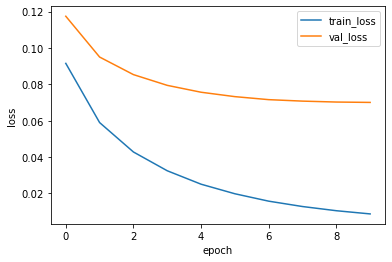

accuracy: 0.9805


In [5]:
class ScratchDeepNeuralNetrowkClassifier():

    def __init__(self, epoch, batch_size, n_nodes1, 
                 n_nodes2, n_output, verbose, init_type, opt_type, act_type):
        self.verbose = verbose
        self.batch_size = batch_size
        self.epoch = epoch
        
        self.n_features = 784
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output

        self.lr = 0.01  #学習率
        self.sigma = 0.1 #重みの初期値のハイパーパラメータ

        self.loss_e = np.array([])  #訓練データのlossを保存する。
        self.loss_v = np.array([])  #検証データのlossを保存する。
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        
        #初期化手法の切り替え
        init_type = 3
        if init_type == 1:
            Initializer = SimpleInitializer(self.sigma)
        if init_type == 2:
            Initializer = XavierInitializer(self.sigma) 
        if init_type == 3:
            Initializer = HeInitializer(self.sigma) 

        #パラメータ更新手法の切り替え
        opt_type = 2
        if opt_type == 1:
            optimizer = SGD(self.lr) 
        if opt_type == 2:
            optimizer = AdaGrad(self.lr)

        #活性化関数の切り替え(1: Tanh(), 2:ReLU()) 
        act_type = 2       
           
        #レイヤーの設計
        self.FC1 = FC(self.n_features, self.n_nodes1, Initializer, optimizer)
        if act_type == 1:
            self.activation1 = Tanh()
        if act_type == 2:
            self.activation1 = ReLU()
            
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, Initializer, optimizer)
        if act_type == 1:
            self.activation2 = Tanh()
        if act_type == 2:
            self.activation2 = ReLU()
        
        self.FC3 = FC(self.n_nodes2, self.n_output, Initializer, optimizer)
        self.activation3 = Softmax()
               
        #パラメータ更新
        for epo in range(self.epoch):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:

                #バッチ学習するデータをXとする。
                X = mini_X_train
                #y_trainを　one-hot表現に変換する。
                Y = self._one_hot_encoding(mini_y_train)
                
                #イテレーションごとのフォワード
                Z = self._forward_prop(X)
                
                #イテレーションごとのバックワード
                dZ0 = self._backward_prop(Z, Y)

            #損失関数の計算
            self._calc_loss(X_train, y_train, X_val, y_val)

            #エポック毎の損失関数を表示
            print(f'epoch: {epo+1:02}, loss: {self.loss_e[-1]:.2e}, loss_val: {self.loss_v[-1]:.2e}')

        #学習による損失関数の減少をプロット
        if self.verbose:
            x_idx = range(len(self.loss_e))
            plt.plot(x_idx, self.loss_e, label='train_loss')
            plt.plot(x_idx, self.loss_v, label='val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()
        
    def _forward_prop(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        return Z3
    
    def _backward_prop(self, Z, Y):
        dA3 = self.activation3.backward(Z, Y) 
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) 
        return dZ0

    #推定
    def predict(self, X_test):
        Z = self._forward_prop(X_test)
        y_pred = np.argmax(Z, axis=1)
        return y_pred
    
    #ラベルデータをone-hot形式に変換
    def _one_hot_encoding(self, y):
        Y = np.zeros((len(y), 10))
        for i, label in enumerate(y):
            Y[i, label] = 1
        return Y
    
    #クロスエントロピー誤差の計算
    def _cross_entropy_error(self, Y, Z):
        L = -1 / len(Y) * np.sum(Y *np.log(Z))        
        return L
    
    #訓練データ、検証データのlossを計算して保存する。
    def _calc_loss(self, X_train, y_train, X_val, y_val):
        
        #訓練データ
        Z_train = self._forward_prop(X_train)
        Y_train = self._one_hot_encoding(y_train)
        self.loss_e = np.append(self.loss_e, self._cross_entropy_error(Y_train, Z_train))

        #検証データ
        Z_val= self._forward_prop(X_val)
        Y_val = self._one_hot_encoding(y_val)
        self.loss_v = np.append(self.loss_v, self._cross_entropy_error(Y_val, Z_val))
            
        return

class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.B -= self.lr * layer.dB
        layer.W -= self.lr * layer.dW
        return layer
    
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        
        #layer.HW += np.mean(layer.dW,axis=0) ** 2
        #layer.HB += np.mean(layer.dB,axis=0) ** 2
        layer.HW += layer.dW ** 2
        layer.HB += layer.dB ** 2

        layer.W -= self.lr / np.sqrt(layer.HW)  * layer.dW
        layer.B -= self.lr / np.sqrt(layer.HB) * layer.dB
        return layer
    
    
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2,)

class XavierInitializer:
    def __init__(self, sigma):  
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2,)

class HeInitializer:
    def __init__(self, sigma):  
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2/n_nodes1)
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2,)

    
class FC:    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
        #AdaGradでの勾配の二乗和を保存
        self.HW =0.0001 #初期値０だと、Zero Devidedが発生してしまうため非ゼロとしている。
        self.HB = 0.0001
    
    def forward(self,Z):
        self.Z = Z  #Zはbackward側でも使用するのでself変数とする。
        self.A = self.Z @ self.W + self.B
        return self.A
        
    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = (self.Z.T) @ dA 
        self.dZ = dA @ (self.W.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return self.dZ

            
#活性化関数（ハイパボリックタンジェント）
class Tanh():    
    def __init__(self):
        pass
    
    def forward(self, A):
        self.Z = np.tanh(A)  #Zはbackward側でも使用するのでself変数とする。
        return self.Z
        
    def backward(self, dZ):
        dA = dZ * (1 - self.Z ** 2)
        return dA 
    
#活性化関数（ReLU)
class ReLU():
    def __init__(self):
        pass
    
    def forward(self, A):
        A[A<=0] = 0
        self.Z = A
        return self.Z
    
    def backward(self, dZ):
        temp = self.Z
        temp[temp>0] = 1
        return dZ * temp

#活性化関数（シグモイド）
#Class Sigmoid(self, A):
#    return  1 / (1 + np.exp(-1 * A))

#ソフトマックス関数
class Softmax():
    def __init__(self):
        pass
    
    def forward(self, A):
        A -= np.max(A)
        ex = np.exp(A)
        return ex / (np.sum(ex, axis=1)).reshape(-1,1)

    def backward(self, Z, Y):
        return 1 / len(Y) * (Z - Y)


#訓練データ、テストデータの分割
X_train2, X_test, y_train2, y_test = train_test_split(X_train, y_train, test_size=0.2)

#機械学習インスタンスの作成
#init_type 1:Simpe, 2:Xavier, 3:He
#opt_type 1:SGD, 2:AdaGrad
#act_type 1:Tanh, 2:ReLU
dnn = ScratchDeepNeuralNetrowkClassifier(verbose = True, epoch = 10,
            batch_size = 20, n_nodes1 = 400, n_nodes2 = 200, n_output = 10,
                    init_type=3, opt_type=2, act_type=2)

#機械学習
dnn.fit(X_train2, y_train2, X_test, y_test)

#機械学習による推定
y_pred = dnn.predict(X_test)

#精度の確認
acc = accuracy_score(y_test, y_pred)
print('accuracy:', acc)

### 【問題１〜９】パターン②
###   ３層、初期値:Simple、更新:SGD、活性化関数:Tanh

epoch: 01, loss: 8.64e-02, loss_val: 1.09e-01
epoch: 02, loss: 5.63e-02, loss_val: 8.80e-02
epoch: 03, loss: 4.15e-02, loss_val: 7.96e-02
epoch: 04, loss: 3.19e-02, loss_val: 7.47e-02
epoch: 05, loss: 2.49e-02, loss_val: 7.12e-02
epoch: 06, loss: 1.97e-02, loss_val: 6.90e-02
epoch: 07, loss: 1.57e-02, loss_val: 6.74e-02
epoch: 08, loss: 1.28e-02, loss_val: 6.64e-02
epoch: 09, loss: 1.05e-02, loss_val: 6.59e-02
epoch: 10, loss: 8.84e-03, loss_val: 6.58e-02


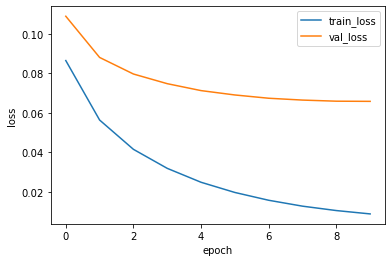

accuracy: 0.9804166666666667


In [7]:
#訓練データ、テストデータの分割
X_train2, X_test, y_train2, y_test = train_test_split(X_train, y_train, test_size=0.2)
#機械学習インスタンスの作成
#init_type 1:Simpe, 2:Xavier, 3:He
#opt_type 1:SGD, 2:AdaGrad
#act_type 1:Tanh, 2:ReLU
dnn4 = ScratchDeepNeuralNetrowkClassifier(verbose = True, epoch = 10,
            batch_size = 20, n_nodes1 = 400, n_nodes2 = 200, n_output = 10,
                    init_type=1, opt_type=1, act_type=1)

#機械学習
dnn4.fit(X_train2, y_train2, X_test, y_test)

#機械学習による推定
y_pred = dnn4.predict(X_test)

#精度の確認
acc = accuracy_score(y_test, y_pred)
print('accuracy:', acc)

### 【問題１〜９】パターン③
###   ４層、初期値:Xavier、更新:AdaGrad、活性化関数:Tanh

epoch: 01, loss: 9.47e-02, loss_val: 1.16e-01
epoch: 02, loss: 5.68e-02, loss_val: 9.26e-02
epoch: 03, loss: 3.88e-02, loss_val: 8.71e-02
epoch: 04, loss: 2.68e-02, loss_val: 8.56e-02
epoch: 05, loss: 2.94e-02, loss_val: 1.00e-01
epoch: 06, loss: 1.37e-02, loss_val: 8.95e-02
epoch: 07, loss: 1.37e-02, loss_val: 9.21e-02
epoch: 08, loss: 6.75e-03, loss_val: 8.84e-02
epoch: 09, loss: 4.17e-03, loss_val: 8.77e-02
epoch: 10, loss: 2.15e-03, loss_val: 8.73e-02


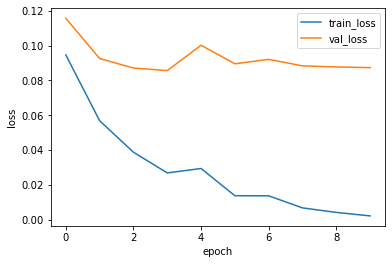

accuracy: 0.9805


In [116]:
class ScratchDeepNeuralNetrowkClassifier_4_layer():

    def __init__(self, epoch, batch_size, n_nodes1, 
                 n_nodes2, n_nodes3, n_output, verbose = True, init_type=3, opt_type=2, act_type=2):
        self.verbose = verbose
        self.batch_size = batch_size
        self.epoch = epoch
        
        self.n_features = 784
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_nodes3 = n_nodes3
        self.n_output = n_output

        self.lr = 0.01  #学習率
        self.sigma = 0.1 #重みの初期値のハイパーパラメータ

        self.loss_e = np.array([])  #訓練データのlossを保存する。
        self.loss_v = np.array([])  #検証データのlossを保存する。
        
    def fit(self, X_train, y_train, X_val=None, y_val=None):
        
        #初期化手法の切り替え
        init_type = 3
        if init_type == 1:
            Initializer = SimpleInitializer(self.sigma)
        if init_type == 2:
            Initializer = XavierInitializer(self.sigma) 
        if init_type == 3:
            Initializer = HeInitializer(self.sigma) 

        #パラメータ更新手法の切り替え
        opt_type = 2
        if opt_type == 1:
            optimizer = SGD(self.lr) 
        if opt_type == 2:
            optimizer = AdaGrad(self.lr)

        #活性化関数の切り替え(1: Tanh(), 2:ReLU()) 
        act_type = 2       
           
        #レイヤーの設計
        self.FC1 = FC(self.n_features, self.n_nodes1, Initializer, optimizer)
        if act_type == 1:
            self.activation1 = Tanh()
        if act_type == 2:
            self.activation1 = ReLU()
            
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, Initializer, optimizer)
        if act_type == 1:
            self.activation2 = Tanh()
        if act_type == 2:
            self.activation2 = ReLU()
            
        self.FC3 = FC(self.n_nodes2, self.n_nodes3, Initializer, optimizer)
        if act_type == 1:
            self.activation3 = Tanh()
        if act_type == 2:
            self.activation3 = ReLU()
        
        self.FC4 = FC(self.n_nodes3, self.n_output, Initializer, optimizer)
        self.activation4 = Softmax()
               
        #パラメータ更新
        for epo in range(self.epoch):
            get_mini_batch = GetMiniBatch(X_train, y_train, batch_size=self.batch_size)
            for mini_X_train, mini_y_train in get_mini_batch:

                #バッチ学習するデータをXとする。
                X = mini_X_train
                #y_trainを　one-hot表現に変換する。
                Y = self._one_hot_encoding(mini_y_train)
                
                #イテレーションごとのフォワード
                Z = self._forward_prop(X)
                
                #イテレーションごとのバックワード
                dZ0 = self._backward_prop(Z, Y)

            #損失関数の計算
            self._calc_loss(X_train, y_train, X_val, y_val)

            #エポック毎の損失関数を表示
            print(f'epoch: {epo+1:02}, loss: {self.loss_e[-1]:.2e}, loss_val: {self.loss_v[-1]:.2e}')

        #学習による損失関数の減少をプロット
        if self.verbose:
            x_idx = range(len(self.loss_e))
            plt.plot(x_idx, self.loss_e, label='train_loss')
            plt.plot(x_idx, self.loss_v, label='val_loss')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()
        
    def _forward_prop(self, X):
        A1 = self.FC1.forward(X)
        Z1 = self.activation1.forward(A1)
        A2 = self.FC2.forward(Z1)
        Z2 = self.activation2.forward(A2)
        A3 = self.FC3.forward(Z2)
        Z3 = self.activation3.forward(A3)
        A4 = self.FC4.forward(Z3)
        Z4 = self.activation4.forward(A4)
        return Z4
    
    def _backward_prop(self, Z, Y):
        dA4 = self.activation4.backward(Z, Y) 
        dZ3 = self.FC4.backward(dA4)
        dA3 = self.activation3.backward(dZ3) 
        dZ2 = self.FC3.backward(dA3)
        dA2 = self.activation2.backward(dZ2)
        dZ1 = self.FC2.backward(dA2)
        dA1 = self.activation1.backward(dZ1)
        dZ0 = self.FC1.backward(dA1) 
        return dZ0

    #推定
    def predict(self, X_test):
        Z = self._forward_prop(X_test)
        y_pred = np.argmax(Z, axis=1)
        return y_pred
    
    #ラベルデータをone-hot形式に変換
    def _one_hot_encoding(self, y):
        Y = np.zeros((len(y), 10))
        for i, label in enumerate(y):
            Y[i, label] = 1
        return Y
    
    #クロスエントロピー誤差の計算
    def _cross_entropy_error(self, Y, Z):
        L = -1 / len(Y) * np.sum(Y *np.log(Z))        
        return L
    
    #訓練データ、検証データのlossを計算して保存する。
    def _calc_loss(self, X_train, y_train, X_val, y_val):
        
        #訓練データ
        Z_train = self._forward_prop(X_train)
        Y_train = self._one_hot_encoding(y_train)
        self.loss_e = np.append(self.loss_e, self._cross_entropy_error(Y_train, Z_train))

        #検証データ
        Z_val= self._forward_prop(X_val)
        Y_val = self._one_hot_encoding(y_val)
        self.loss_v = np.append(self.loss_v, self._cross_entropy_error(Y_val, Z_val))
            
        return

class SGD:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        layer.B -= self.lr * layer.dB
        layer.W -= self.lr * layer.dW
        return layer
    
class AdaGrad:
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        
        layer.HW += np.mean(layer.dW,axis=0) ** 2
        layer.HB += np.mean(layer.dB,axis=0) ** 2

        layer.W -= self.lr / np.sqrt(layer.HW)  * layer.dW
        layer.B -= self.lr / np.sqrt(layer.HB) * layer.dB
        return layer
    
    
class SimpleInitializer:
    def __init__(self, sigma):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2,)

class XavierInitializer:
    def __init__(self, sigma):  
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = 1 / np.sqrt(n_nodes1)
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2,)

class HeInitializer:
    def __init__(self, sigma):  
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        self.sigma = np.sqrt(2/n_nodes1)
        return self.sigma * np.random.randn(n_nodes1, n_nodes2)

    def B(self, n_nodes2):
        return self.sigma * np.random.randn(n_nodes2,)

    
class FC:    
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        
        #AdaGradでの勾配の二乗和を保存
        self.HW =0.0001 #初期値０だと、Zero Devidedが発生してしまうため非ゼロとしている。
        self.HB = 0.0001
    
    def forward(self,Z):
        self.Z = Z  #Zはbackward側でも使用するのでself変数とする。
        self.A = self.Z @ self.W + self.B
        return self.A
        
    def backward(self, dA):
        self.dB = np.sum(dA, axis=0)
        self.dW = (self.Z.T) @ dA 
        self.dZ = dA @ (self.W.T)
        
        # 更新
        self = self.optimizer.update(self)
        
        return self.dZ

            
#活性化関数（ハイパボリックタンジェント）
class Tanh():    
    def __init__(self):
        pass
    
    def forward(self, A):
        self.Z = np.tanh(A)  #Zはbackward側でも使用するのでself変数とする。
        return self.Z
        
    def backward(self, dZ):
        dA = dZ * (1 - self.Z ** 2)
        return dA 
    
#活性化関数（ReLU)
class ReLU():
    def __init__(self):
        pass
    
    def forward(self, A):
        A[A<=0] = 0
        self.Z = A
        return self.Z
    
    def backward(self, dZ):
        temp = self.Z
        temp[temp>0] = 1
        return dZ * temp

#活性化関数（シグモイド）
#Class Sigmoid(self, A):
#    return  1 / (1 + np.exp(-1 * A))

#ソフトマックス関数
class Softmax():
    def __init__(self):
        pass
    
    def forward(self, A):
        A -= np.max(A)
        ex = np.exp(A)
        return ex / (np.sum(ex, axis=1)).reshape(-1,1)

    def backward(self, Z, Y):
        return 1 / len(Y) * (Z - Y)


#訓練データ、テストデータの分割
X_train2, X_test, y_train2, y_test = train_test_split(X_train, y_train, test_size=0.2)

#機械学習インスタンスの作成
#init_type 1:Simpe, 2:Xavier, 3:He
#opt_type 1:SGD, 2:AdaGrad
#act_type 1:Tanh, 2:ReLU
dnn5 = ScratchDeepNeuralNetrowkClassifier_4_layer(verbose = True, epoch = 10,
            batch_size = 20, n_nodes1 = 400, n_nodes2 = 200, n_nodes3 = 100, n_output = 10,
                    init_type=3, opt_type=2, act_type=2)

#機械学習
dnn5.fit(X_train2, y_train2, X_test, y_test)

#機械学習による推定
y_pred = dnn5.predict(X_test)

#精度の確認
acc = accuracy_score(y_test, y_pred)
print('accuracy:', acc)

#### →初期値の設定方法や、パラメータ更新手法による汎化性能差に大きな違いは認められなかった。

　また、レイヤー数も必ずしも増やせば増やすほど良いというものでは無いことを実感した。